<a href="https://colab.research.google.com/github/harivarshith/NLP-Assignments-1351/blob/main/NLP_Abhilash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔹 Training FastText + BiLSTM
FastText + BiLSTM | Epoch 1/10 | Loss: 1.366 | Acc: 0.500
FastText + BiLSTM | Epoch 2/10 | Loss: 1.324 | Acc: 1.000
FastText + BiLSTM | Epoch 3/10 | Loss: 1.247 | Acc: 0.750
FastText + BiLSTM | Epoch 4/10 | Loss: 1.231 | Acc: 1.000
FastText + BiLSTM | Epoch 5/10 | Loss: 1.237 | Acc: 0.750
FastText + BiLSTM | Epoch 6/10 | Loss: 1.119 | Acc: 1.000
FastText + BiLSTM | Epoch 7/10 | Loss: 1.158 | Acc: 1.000
FastText + BiLSTM | Epoch 8/10 | Loss: 1.068 | Acc: 1.000
FastText + BiLSTM | Epoch 9/10 | Loss: 1.019 | Acc: 1.000
FastText + BiLSTM | Epoch 10/10 | Loss: 1.112 | Acc: 1.000


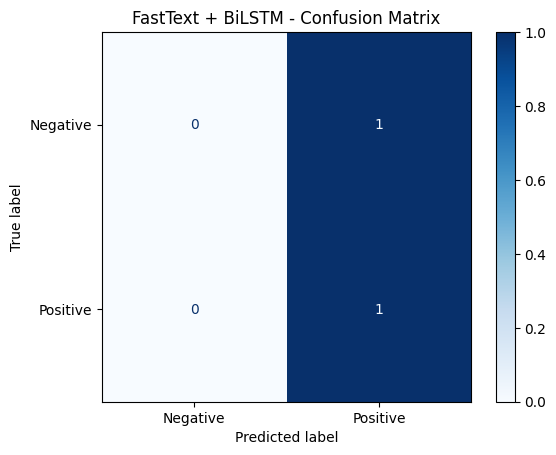

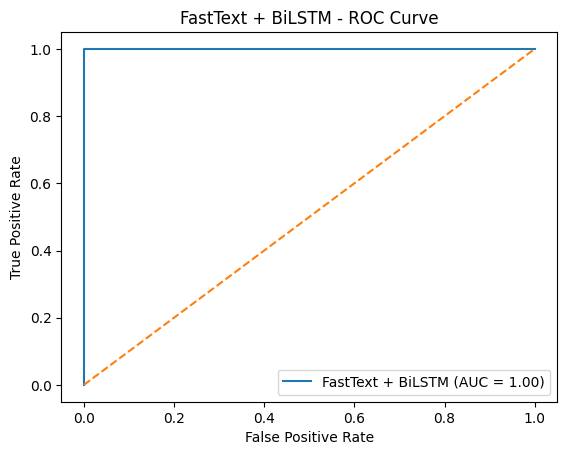

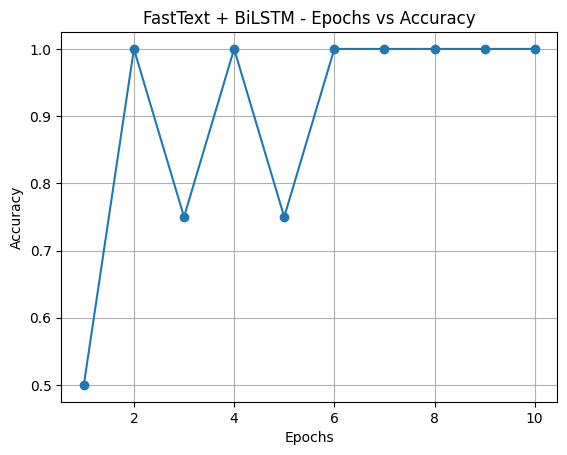

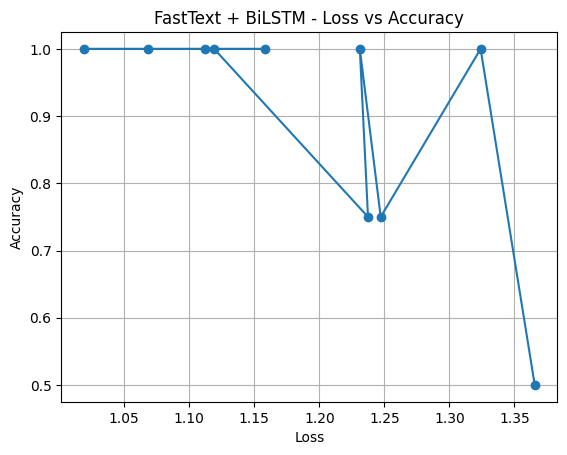


🔹 Training Word2Vec + CNN
Word2Vec + CNN | Epoch 1/10 | Loss: 1.064 | Acc: 0.500
Word2Vec + CNN | Epoch 2/10 | Loss: 0.920 | Acc: 0.750
Word2Vec + CNN | Epoch 3/10 | Loss: 0.449 | Acc: 1.000
Word2Vec + CNN | Epoch 4/10 | Loss: 0.254 | Acc: 1.000
Word2Vec + CNN | Epoch 5/10 | Loss: 0.256 | Acc: 1.000
Word2Vec + CNN | Epoch 6/10 | Loss: 0.107 | Acc: 1.000
Word2Vec + CNN | Epoch 7/10 | Loss: 0.081 | Acc: 1.000
Word2Vec + CNN | Epoch 8/10 | Loss: 0.034 | Acc: 1.000
Word2Vec + CNN | Epoch 9/10 | Loss: 0.016 | Acc: 1.000
Word2Vec + CNN | Epoch 10/10 | Loss: 0.017 | Acc: 1.000


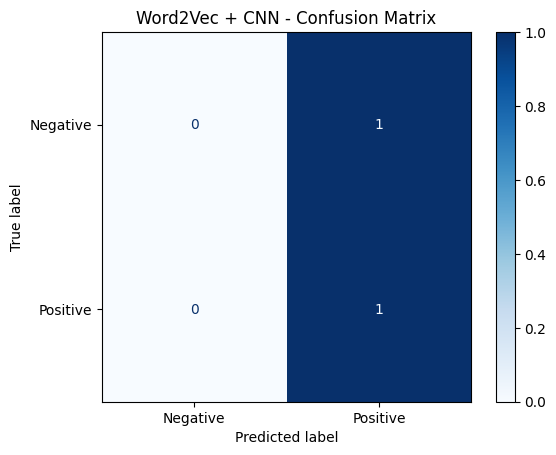

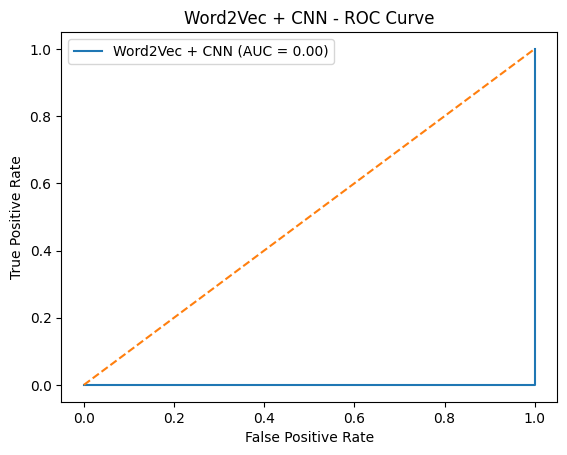

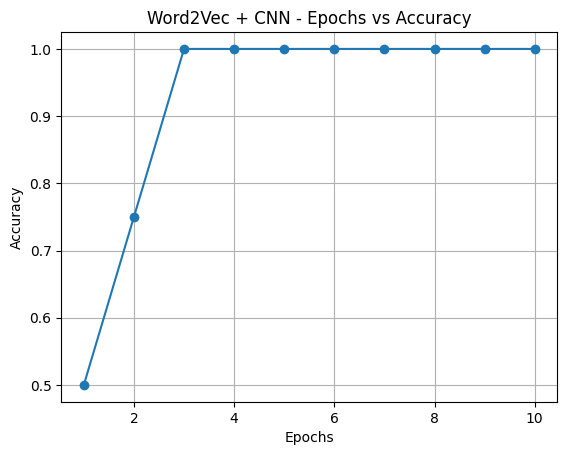

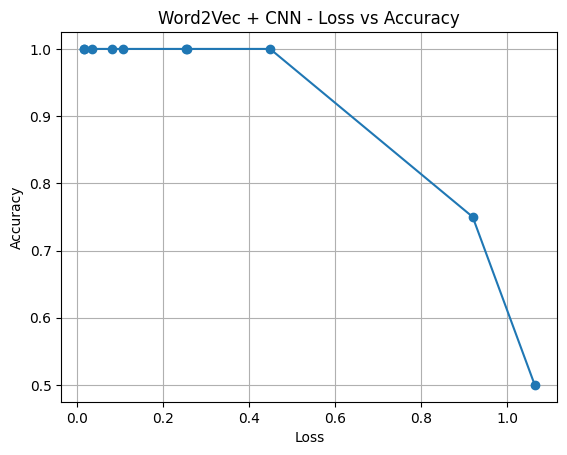

In [2]:
# embeddings_deep_models_eval.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# -----------------------------
# 1️⃣  Toy dataset
# -----------------------------
texts = [
    "I love this movie",
    "This film was terrible",
    "Amazing acting and great story",
    "Worst movie ever",
    "Loved the direction and music",
    "Bad script and poor acting"
]
labels = [1, 0, 1, 0, 1, 0]  # 1=Positive, 0=Negative

# -----------------------------
# 2️⃣  Text preprocessing
# -----------------------------
def tokenize(text):
    return text.lower().split()

# Build vocabulary
all_tokens = [t for txt in texts for t in tokenize(txt)]
vocab = sorted(set(all_tokens))
word2idx = {w: i + 1 for i, w in enumerate(vocab)}  # +1 since 0 is PAD
vocab_size = len(word2idx) + 1
max_len = max(len(tokenize(t)) for t in texts)

def encode(text):
    tokens = tokenize(text)
    idxs = [word2idx.get(t, 0) for t in tokens]
    while len(idxs) < max_len:
        idxs.append(0)
    return idxs[:max_len]

X = torch.tensor([encode(t) for t in texts])
y = torch.tensor(labels)

# Split train/test (4 train, 2 test)
X_train, X_test = X[:4], X[4:]
y_train, y_test = y[:4], y[4:]

# -----------------------------
# 3️⃣  Dataset + DataLoader
# -----------------------------
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=2, shuffle=True)
test_loader  = DataLoader(TextDataset(X_test,  y_test),  batch_size=2, shuffle=False)

# -----------------------------
# 4️⃣  Model 1: FastText + BiLSTM
# -----------------------------
class FastText_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=50, hidden_dim=64, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        out = out[:, -1, :]  # last hidden
        out = self.dropout(out)
        return self.fc(out)

# -----------------------------
# 5️⃣  Model 2: Word2Vec + CNN
# -----------------------------
class Word2Vec_CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=50, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, 100, (k, embed_dim)) for k in [3,4,5]
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(3 * 100, num_classes)

    def conv_block(self, x, conv):
        x = torch.relu(conv(x)).squeeze(3)
        x = torch.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        emb = self.embedding(x).unsqueeze(1)
        x = torch.cat([self.conv_block(emb, c) for c in self.convs], 1)
        x = self.dropout(x)
        return self.fc(x)

# -----------------------------
# 6️⃣  Training + Evaluation
# -----------------------------
def train_model(model, train_loader, test_loader, epochs=10, name="Model"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accs, losses = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, total_loss = 0, 0, 0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        acc = correct / total
        train_accs.append(acc)
        losses.append(total_loss)
        print(f"{name} | Epoch {epoch+1}/{epochs} | Loss: {total_loss:.3f} | Acc: {acc:.3f}")

    # Evaluate on test
    model.eval()
    y_true, y_pred, y_score = [], [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            out = model(Xb)
            probs = torch.softmax(out, dim=1)
            preds = out.argmax(1)
            y_true += yb.tolist()
            y_pred += preds.tolist()
            y_score += probs[:,1].tolist()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.show()

    # Epochs vs Accuracy
    plt.plot(range(1, epochs+1), train_accs, marker='o')
    plt.title(f"{name} - Epochs vs Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    # Loss vs Accuracy
    plt.plot(losses, train_accs, marker='o')
    plt.title(f"{name} - Loss vs Accuracy")
    plt.xlabel("Loss")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

# -----------------------------
# 7️⃣  Run both models
# -----------------------------
print("🔹 Training FastText + BiLSTM")
bilstm_model = FastText_BiLSTM(vocab_size)
train_model(bilstm_model, train_loader, test_loader, name="FastText + BiLSTM")

print("\n🔹 Training Word2Vec + CNN")
cnn_model = Word2Vec_CNN(vocab_size)
train_model(cnn_model, train_loader, test_loader, name="Word2Vec + CNN")
